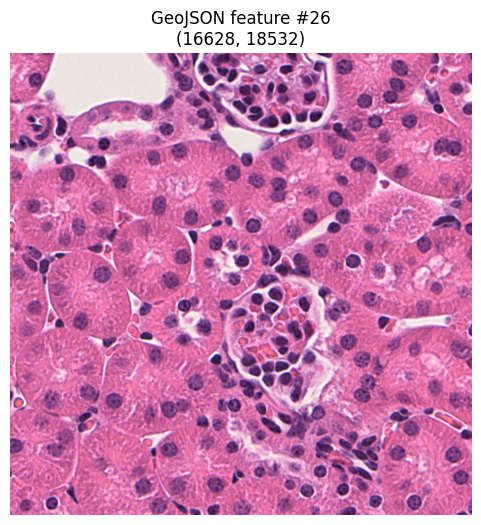

In [2]:
import os, json, math
from urllib.request import urlretrieve

import numpy as np
import cv2
import torch
import openslide
from skimage.color import rgb2hed
import matplotlib.pyplot as plt

try:
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "git+https://github.com/facebookresearch/segment-anything.git"])
    from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Paths
geojson_path = '/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson'
ndpi_path = '/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi'

PADDING = 200
FEATURE_INDEX = 25  # 4th region (0-based indexing)

# Load GeoJSON
with open(geojson_path, 'r') as f:
    geo = json.load(f)

feature = geo['features'][FEATURE_INDEX]
coords = np.array(feature['geometry']['coordinates'][0])

# Compute bounding box
min_x = int(coords[:, 0].min())
min_y = int(coords[:, 1].min())
max_x = int(coords[:, 0].max())
max_y = int(coords[:, 1].max())

# Apply padding
min_x = max(0, min_x - PADDING)
min_y = max(0, min_y - PADDING)
w = (max_x + PADDING) - min_x
h = (max_y + PADDING) - min_y

# Open slide
slide = openslide.OpenSlide(ndpi_path)

# Read region
patch = slide.read_region((min_x, min_y), 0, (w, h)).convert("RGB")
patch_np = np.asarray(patch, dtype=np.uint8)

# Display
plt.figure(figsize=(6, 6))
plt.imshow(patch)
plt.title(f"GeoJSON feature #{FEATURE_INDEX + 1}\n({min_x}, {min_y})")
plt.axis("off")
plt.show()


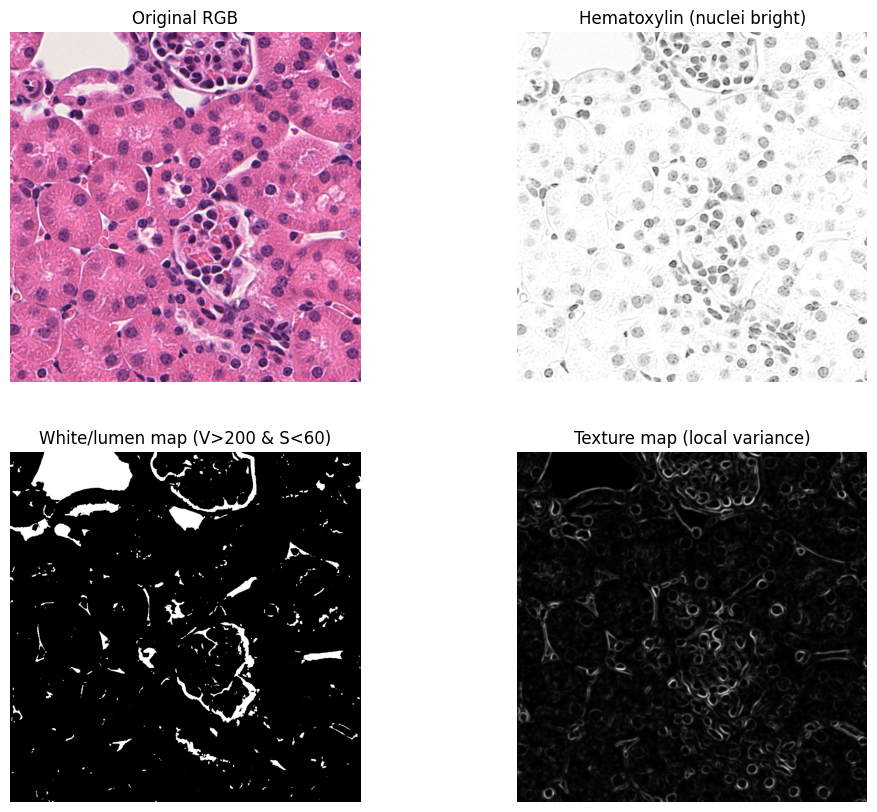

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2hed

img = patch_np

# --- 1) HED deconvolution (hematoxylin "blue nuclei") ---
hed = rgb2hed(img)
H = hed[:, :, 0]  # hematoxylin
Hn = (H - H.min()) / (H.max() - H.min() + 1e-8)  # normalize 0..1
Hn_inv = 1.0 - Hn  # invert so nuclei become bright

# --- 2) Low saturation + high value (white-ish lumen/capsule) ---
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
S = hsv[:, :, 1].astype(np.float32)
V = hsv[:, :, 2].astype(np.float32)
white_map = ((V > 200) & (S < 60)).astype(np.float32)

# --- 3) Texture map: local variance (glomerulus tends to be "busy") ---
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0
mu = cv2.GaussianBlur(gray, (0,0), 2)
mu2 = cv2.GaussianBlur(gray*gray, (0,0), 2)
var = np.clip(mu2 - mu*mu, 0, None)
varn = (var - var.min()) / (var.max() - var.min() + 1e-8)

# --- 4) Edge energy (Laplacian) ---
lap = cv2.Laplacian((gray*255).astype(np.uint8), cv2.CV_32F, ksize=3)
lap = np.abs(lap)
lapn = (lap - lap.min()) / (lap.max() - lap.min() + 1e-8)

# Plot
plt.figure(figsize=(12,10))
plt.subplot(2,2,1); plt.imshow(img); plt.title("Original RGB"); plt.axis("off")
plt.subplot(2,2,2); plt.imshow(Hn_inv, cmap="gray"); plt.title("Hematoxylin (nuclei bright)"); plt.axis("off")
plt.subplot(2,2,3); plt.imshow(white_map, cmap="gray"); plt.title("White/lumen map (V>200 & S<60)"); plt.axis("off")
plt.subplot(2,2,4); plt.imshow(varn, cmap="gray"); plt.title("Texture map (local variance)"); plt.axis("off")
plt.show()


In [4]:
import numpy as np, cv2
from skimage.color import rgb2hed
from scipy.ndimage import binary_fill_holes

def keep_largest_component(mask, prefer_center=True):
    mask = mask.astype(np.uint8)
    num, lab = cv2.connectedComponents(mask)
    if num <= 1:
        return mask.astype(bool)
    H, W = mask.shape
    cx, cy = W/2, H/2

    best_i, best_score = None, -1e18
    for i in range(1, num):
        comp = (lab == i)
        area = comp.sum()
        if area < 50:
            continue
        if prefer_center:
            ys, xs = np.where(comp)
            mx, my = xs.mean(), ys.mean()
            dist2 = (mx-cx)**2 + (my-cy)**2
            score = area - 0.001*dist2  # area dominates, slight center preference
        else:
            score = area
        if score > best_score:
            best_score, best_i = score, i
    if best_i is None:
        return np.zeros_like(mask, dtype=bool)
    return (lab == best_i)

def clean_mask(mask, close_ks=9, open_ks=5, fill=True):
    m = mask.astype(np.uint8) * 255
    if close_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    if open_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)
    m = (m > 0)
    if fill:
        m = binary_fill_holes(m)
    return m

import numpy as np
import cv2
from skimage.color import rgb2hed
import matplotlib.pyplot as plt

def mask_from_hematoxylin_debug(img_rgb,
                                sigma_nuc=1.5,
                                radius_px=80,
                                center_weight=2.0,   # kept for compatibility (optional)
                                post_close_ks=0,
                                post_open_ks=0,
                                show=True):
    """
    Circular region centered at the location where the Otsu nuclei mask
    has the MOST foreground pixels inside a radius_px circle.
    """

    # 1) HED → hematoxylin → nuclei intensity
    hed = rgb2hed(img_rgb)
    H = hed[:, :, 0]
    Hn = (H - H.min()) / (H.max() - H.min() + 1e-8)
    nuclei = 1.0 - Hn

    # 2) Otsu → binary nuclei image
    nuclei8 = (nuclei * 255).astype(np.uint8)
    nuclei8b = cv2.GaussianBlur(nuclei8, (0, 0), sigma_nuc)
    _, bw = cv2.threshold(
        nuclei8b, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 3) Rasterize to {0,1}
    bw01 = (bw == 0).astype(np.float32)

    Hh, Ww = bw01.shape
    cx0, cy0 = Ww / 2.0, Hh / 2.0

    # 4) Circular-kernel convolution = count of 1s in circle
    r = int(radius_px)
    yy, xx = np.ogrid[-r:r+1, -r:r+1]
    kernel = ((xx*xx + yy*yy) <= r*r).astype(np.float32)

    dens = cv2.filter2D(
        bw01, -1, kernel,
        borderType=cv2.BORDER_CONSTANT
    )

    dens_norm = dens / (dens.max() + 1e-8)

    # 5) Optional soft center bias (continuous, no masking)
    score = dens.copy()
    if center_weight > 0:
        Y, X = np.mgrid[0:Hh, 0:Ww]
        r2 = ((X - cx0)**2 + (Y - cy0)**2) / ((0.5 * min(Hh, Ww))**2 + 1e-8)
        w = np.exp(-center_weight * r2)
        score *= w

    # 6) Pick global maximum
    cy, cx = np.unravel_index(np.argmax(score), score.shape)

    # 7) Output circle mask
    Y, X = np.mgrid[0:Hh, 0:Ww]
    circle = ((X - cx)**2 + (Y - cy)**2) <= (r * r)
    m = (circle.astype(np.uint8) * 255)

    m_pre = m.copy()
    if post_close_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (post_close_ks, post_close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    if post_open_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (post_open_ks, post_open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)

    m_bool = (m > 0)

    # ---------------- VISUALIZATION ----------------
    if show:
        img_disp = img_rgb
        if img_disp.dtype != np.uint8:
            img_disp = np.clip(img_disp, 0, 255).astype(np.uint8)

        overlay = img_disp.copy()
        cv2.circle(overlay, (int(cx), int(cy)), r, (255, 0, 0), 2)
        cv2.circle(overlay, (int(cx), int(cy)), 2, (255, 0, 0), -1)

        heat = (dens_norm * 255).astype(np.uint8)
        heat_color = cv2.applyColorMap(heat, cv2.COLORMAP_JET)[:, :, ::-1]
        heat_overlay = cv2.addWeighted(overlay, 0.6, heat_color, 0.4, 0)

        plt.figure(figsize=(16, 10))
        plt.subplot(2, 4, 1); plt.title("Original"); plt.imshow(img_disp); plt.axis("off")
        plt.subplot(2, 4, 2); plt.title("Hematoxylin (H)"); plt.imshow(H, cmap="gray"); plt.axis("off")
        plt.subplot(2, 4, 3); plt.title("Nuclei map (1-Hn)"); plt.imshow(nuclei, cmap="gray"); plt.axis("off")
        plt.subplot(2, 4, 4); plt.title("Otsu nuclei mask"); plt.imshow(bw, cmap="gray"); plt.axis("off")
        plt.subplot(2, 4, 5); plt.title(f"Circle count (r={r})"); plt.imshow(dens_norm, cmap="gray"); plt.axis("off")
        plt.subplot(2, 4, 6); plt.title("Score"); plt.imshow(score / (score.max()+1e-8), cmap="gray"); plt.axis("off")
        plt.subplot(2, 4, 7); plt.title("Heat overlay"); plt.imshow(heat_overlay); plt.axis("off")
        plt.subplot(2, 4, 8); plt.title("Final circle mask"); plt.imshow(m_bool, cmap="gray"); plt.axis("off")
        plt.show()

    return m_bool, (int(cx), int(cy)), dens


import numpy as np
import cv2

def mask_from_texture(
    img_rgb,
    var_sigma=2,          # variance smoothing (same as before)
    blur_sigma=3,         # post-normalization smoothing (same as before)
    thr_q=85,             # percentile threshold
    center_weight=2.0,    # 0 = no bias; higher = stronger center preference
    close_ks=13,
    open_ks=7,
    fill=True,
    prefer_center=True,
):
    """
    Texture mask with soft center bias.
    - center_weight controls how strongly we prefer texture near the ROI center.
      Try: 2.0 (mild), 4.0 (medium), 8.0 (strong)
    """

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    # --- texture variance ---
    mu  = cv2.GaussianBlur(gray, (0, 0), var_sigma)
    mu2 = cv2.GaussianBlur(gray * gray, (0, 0), var_sigma)
    var = np.clip(mu2 - mu * mu, 0, None)

    # normalize to 0..1
    varn = (var - var.min()) / (var.max() - var.min() + 1e-8)

    # smooth (same spirit as your v8 blur)
    varn = cv2.GaussianBlur(varn, (0, 0), blur_sigma)

    # --- center bias (soft, continuous) ---
    if center_weight and center_weight > 0:
        H, W = varn.shape
        Y, X = np.mgrid[0:H, 0:W]
        cx, cy = (W - 1) / 2.0, (H - 1) / 2.0

        # normalized radius^2 in [0, ~2]
        r2 = ((X - cx) ** 2 + (Y - cy) ** 2) / ((0.5 * min(H, W)) ** 2 + 1e-8)

        # gaussian-like falloff; center_weight controls steepness
        w = np.exp(-center_weight * r2)

        varn_w = varn * w
    else:
        varn_w = varn

    # threshold on weighted texture map
    # (percentile on weighted map, not original)
    thr = np.percentile(varn_w, thr_q)
    m = varn_w >= thr

    # clean + keep component (your helpers)
    m = clean_mask(m, close_ks=close_ks, open_ks=open_ks, fill=fill)
    m = keep_largest_component(m, prefer_center=prefer_center)

    return m


def mask_from_white_lumen(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]
    white = ((V > 200) & (S < 60))
    # invert to get "non-white tissue mass" around lumen/capsule
    m = ~white
    m = clean_mask(m, close_ks=9, open_ks=5, fill=True)
    m = keep_largest_component(m, prefer_center=True)
    return m



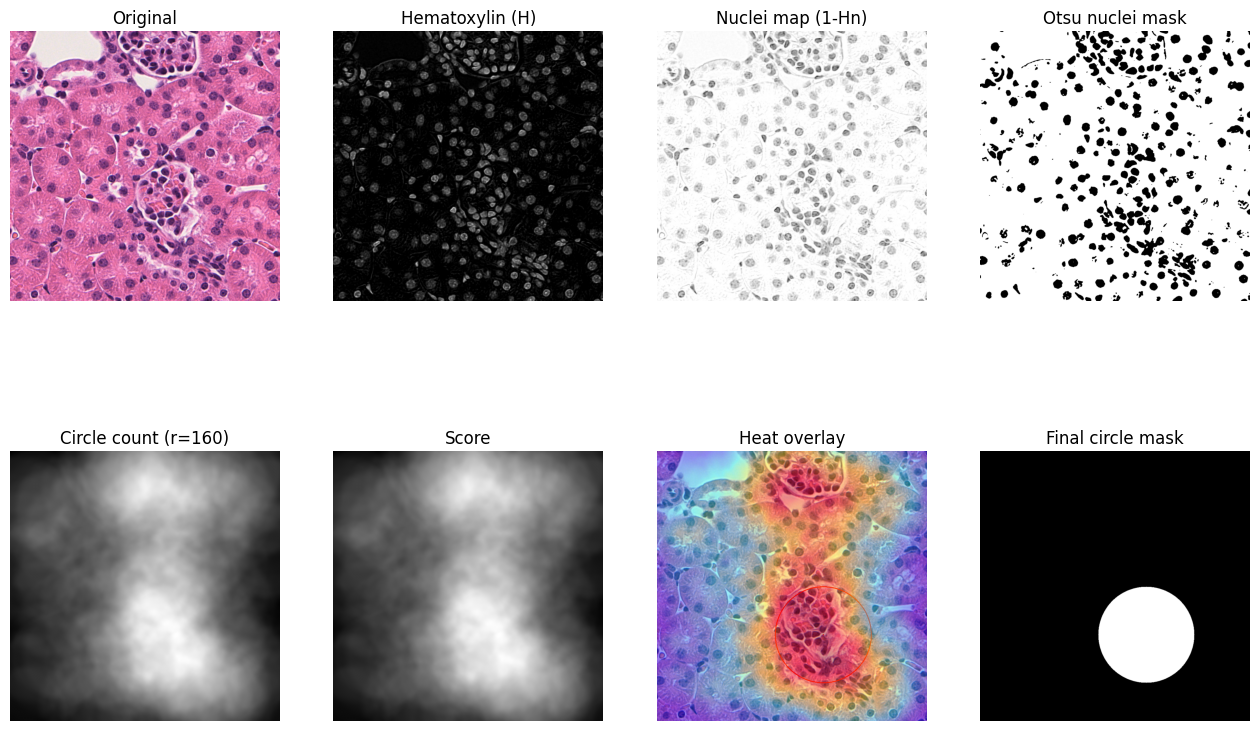

In [5]:
mH, (cx, cy), dens = mask_from_hematoxylin_debug(
    patch_np,
    radius_px=160,
    center_weight=0,   # try 0, 1, 2, 4
    show=True
)

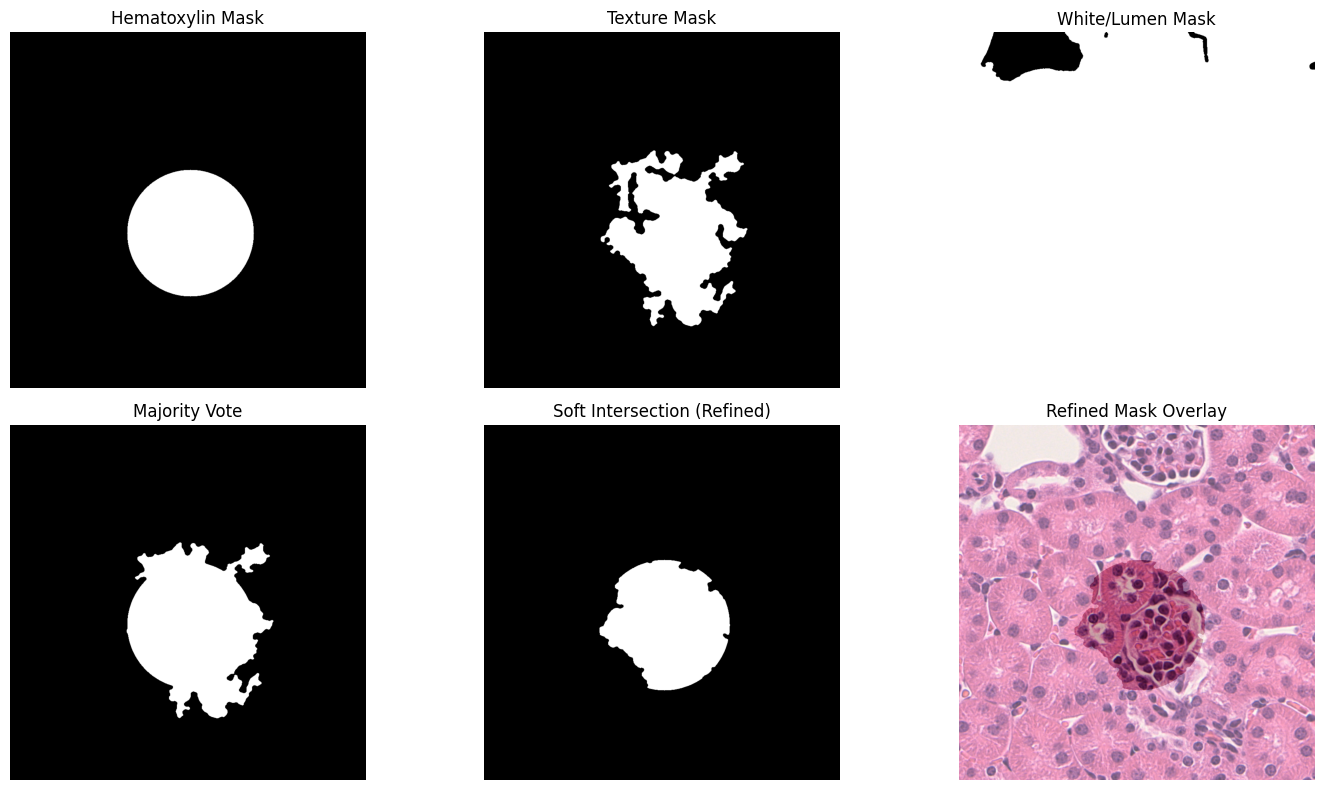

In [6]:
def dilate(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
    return cv2.dilate(mask.astype(np.uint8)*255, kk) > 0

def erode(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
    return cv2.erode(mask.astype(np.uint8)*255, kk) > 0

mH, _, _ = mask_from_hematoxylin_debug(patch_np, radius_px=160, center_weight=1, show=False)
mT = mask_from_texture(patch_np)
mW = mask_from_white_lumen(patch_np)

# Majority vote (robust)
vote = (mH.astype(int) + mT.astype(int) + mW.astype(int))
m_major = (vote >= 2)
m_major = clean_mask(m_major, close_ks=11, open_ks=5, fill=True)
m_major = keep_largest_component(m_major, prefer_center=True)

# Tight interior via soft-intersection (dilate then intersect)
m_softI = dilate(mH, 11) & dilate(mT, 11) & dilate(mW, 11)
m_softI = clean_mask(m_softI, close_ks=9, open_ks=5, fill=True)
m_softI = keep_largest_component(m_softI, prefer_center=True)

# If soft-intersection is empty, fall back to majority
if m_softI.sum() < 200:
    m_softI = m_major

# --- Visualization ---
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.imshow(mH, cmap='gray')
plt.title("Hematoxylin Mask")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(mT, cmap='gray')
plt.title("Texture Mask")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(mW, cmap='gray')
plt.title("White/Lumen Mask")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(m_major, cmap='gray')
plt.title("Majority Vote")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(m_softI, cmap='gray')
plt.title("Soft Intersection (Refined)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(patch_np)
plt.imshow(m_softI, alpha=0.3, cmap='Reds')
plt.title("Refined Mask Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(899.5), np.float64(899.5), np.float64(-0.5))

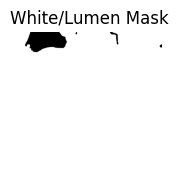

In [7]:
def mask_from_white_lumen(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]
    white = ((V > 200) & (S < 60))
    # invert to get "non-white tissue mass" around lumen/capsule
    m = ~white
    m = clean_mask(m, close_ks=9, open_ks=5, fill=True)
    m = keep_largest_component(m, prefer_center=True)
    return m
    
mW = mask_from_white_lumen(patch_np)

plt.subplot(2, 3, 3)
plt.imshow(mW, cmap='gray')
plt.title("White/Lumen Mask")
plt.axis('off')

In [8]:
import numpy as np
import cv2

def adaptive_white_map(rgb, v_q=90, s_q=35):
    """White-ish pixels: high V and low S, using percentiles (robust across staining)."""
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1].astype(np.float32)
    V = hsv[:, :, 2].astype(np.float32)
    v_thr = np.percentile(V, v_q)
    s_thr = np.percentile(S, s_q)
    return (V >= v_thr) & (S <= s_thr)

def circularity(contour):
    area = cv2.contourArea(contour)
    peri = cv2.arcLength(contour, True)
    if peri <= 1e-6:
        return 0.0
    return float(4.0 * np.pi * area / (peri * peri))

def find_white_loop_mask(
    img_rgb,
    center_xy,
    roi_radius=180,
    v_q=90,
    s_q=35,
    canny1=40,
    canny2=120,
    close_ks=9,
    close_iters=2,
    area_range=(800, 60000),
    require_center_inside=False,
):
    """
    Returns:
      mask_full: bool mask in full image coordinates
      best_contour_full: contour in full image coords (or None)
      debug: dict of intermediate images (roi maps)
    """
    H, W = img_rgb.shape[:2]
    cx, cy = map(int, center_xy)

    # --- crop ROI around the proposed glomerulus center ---
    x0 = max(0, cx - roi_radius)
    x1 = min(W, cx + roi_radius)
    y0 = max(0, cy - roi_radius)
    y1 = min(H, cy + roi_radius)
    roi = img_rgb[y0:y1, x0:x1].copy()

    # --- white-ish rim map ---
    white = adaptive_white_map(roi, v_q=v_q, s_q=s_q).astype(np.uint8) * 255
    white_blur = cv2.GaussianBlur(white, (5, 5), 0)

    # --- edges + closing to form loops ---
    edges = cv2.Canny(white_blur, canny1, canny2)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, k, iterations=close_iters)

    # --- contour search ---
    contours, hier = cv2.findContours(closed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    roi_cx = (x1 - x0) / 2.0
    roi_cy = (y1 - y0) / 2.0

    best = None
    best_score = -1e18

    for c in contours:
        area = cv2.contourArea(c)
        if area < area_range[0] or area > area_range[1]:
            continue

        circ = circularity(c)

        # distance from ROI center to contour (signed): + if inside, - if outside
        signed_dist = cv2.pointPolygonTest(c, (roi_cx, roi_cy), True)
        dist_penalty = abs(signed_dist)

        if require_center_inside and signed_dist < 0:
            continue

        # score: prefer circular, reasonable area, and close to ROI center
        score = (6.0 * circ) + (0.0008 * area) - (0.06 * dist_penalty)

        if score > best_score:
            best_score = score
            best = c

    # --- build full-size mask ---
    mask_full = np.zeros((H, W), dtype=np.uint8)
    best_contour_full = None

    if best is not None:
        best_contour_full = best + np.array([[[x0, y0]]], dtype=np.int32)
        cv2.drawContours(mask_full, [best_contour_full], -1, 255, thickness=-1)

        # optional cleanup
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        mask_full = cv2.morphologyEx(mask_full, cv2.MORPH_CLOSE, k2, iterations=1)

    debug = {
        "roi": roi,
        "white": white,
        "edges": edges,
        "closed": closed,
        "roi_bbox": (x0, y0, x1, y1),
        "best_score": best_score,
    }

    return (mask_full > 0), best_contour_full, debug


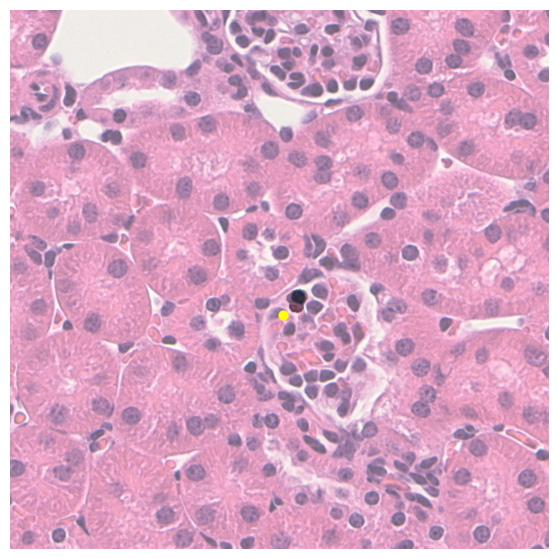

In [9]:
mH, (cx, cy), dens = mask_from_hematoxylin_debug(patch_np, radius_px=160, center_weight=1, show=False)

loop_mask, loop_contour, dbg = find_white_loop_mask(
    patch_np,
    center_xy=(cx, cy),
    roi_radius=180,
    v_q=90,
    s_q=35,
    close_ks=11,
    close_iters=2,
    area_range=(800, 30000),
    require_center_inside=False,   # set True if your loops are usually closed
)

plt.figure(figsize=(7,7))
plt.imshow(patch_np)
plt.imshow(loop_mask, alpha=0.35, cmap="Greens")
plt.scatter([cx],[cy], c="yellow", s=40)
plt.axis("off")
plt.show()

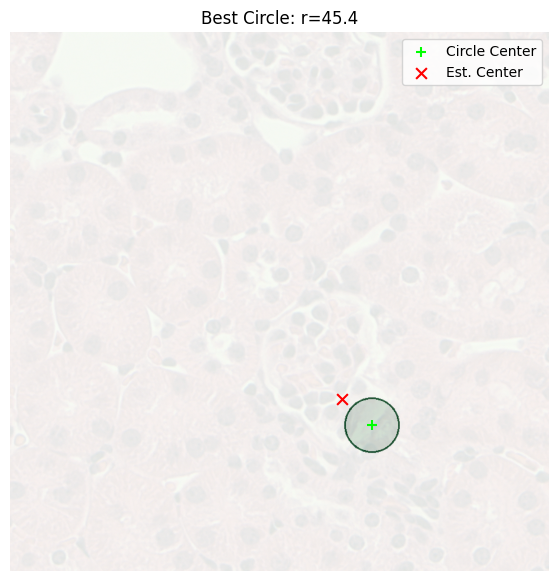

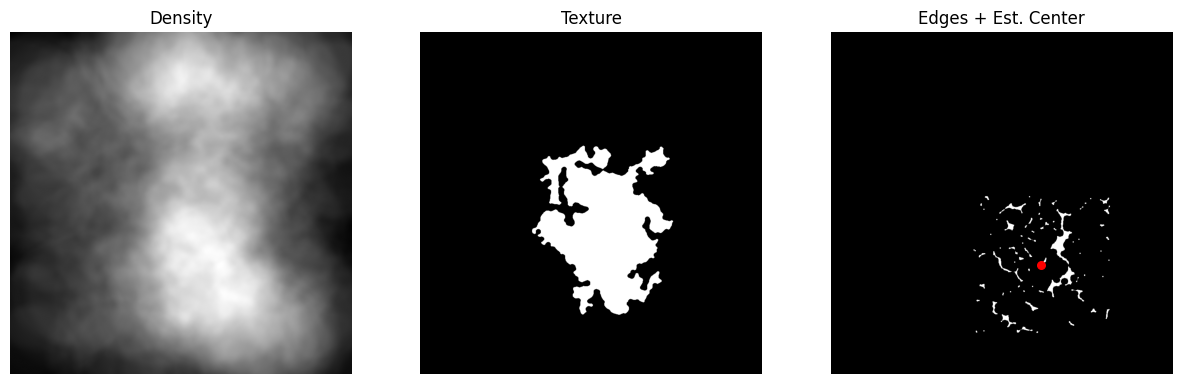

In [10]:
def detect_bowmans_circle_and_plot(
    patch_np,
    # ---------- center estimation ----------
    sigma_nuc=1.5,
    nuclei_radius_px=160,
    center_weight=2.0,

    # ---------- whitest pixels map ----------
    v_q=95,
    s_q=30,
    open_ks=3,

    # ---------- edges + closing ----------
    canny1=30,
    canny2=90,
    close_ks=9,
    close_iters=2,

    # ---------- ROI around center ----------
    roi_radius=180,

    # ---------- circle fit constraints ----------
    min_radius=40,
    max_radius=140,
    min_points=30,  # minimum points in contour to consider fitting a circle

    # ---------- plotting ----------
    show_debug=True,
):
    """
    Improved Bowmans capsule detection:
      1) Estimate center by combining Nuclei Density * Texture Variance.
      2) Compute "whitest pixels" mask -> Edges -> Close Edges.
      3) Find connected components (contours) in the edge map.
      4) Fit MinEnclosingCircle to each significant contour.
      5) Select the circle whose center is closest to the estimated center (1).
    """
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    from skimage.color import rgb2hed

    H, W = patch_np.shape[:2]

    # -----------------------------------------------------
    # (1) Estimate Center: Intersection of H-density and Texture
    # -----------------------------------------------------
    # A. Hematoxylin density
    hed = rgb2hed(patch_np)
    Hchan = hed[:, :, 0]
    Hn = (Hchan - Hchan.min()) / (Hchan.max() - Hchan.min() + 1e-8)
    nuclei = 1.0 - Hn
    nuclei8 = (nuclei * 255).astype(np.uint8)
    nuclei8b = cv2.GaussianBlur(nuclei8, (0, 0), sigma_nuc)
    _, bw = cv2.threshold(nuclei8b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bw01 = (bw > 0).astype(np.float32)
    if bw01.mean() > 0.5: bw01 = 1.0 - bw01

    r_kern = int(nuclei_radius_px)
    yy, xx = np.ogrid[-r_kern:r_kern+1, -r_kern:r_kern+1]
    kernel = ((xx*xx + yy*yy) <= r_kern**2).astype(np.float32)
    dens = cv2.filter2D(bw01, -1, kernel, borderType=cv2.BORDER_CONSTANT)

    # B. Texture mask
    mT = mask_from_texture(patch_np, center_weight=center_weight, prefer_center=True)
    
    # C. Intersection
    combined_score = dens * mT.astype(np.float32)
    cy_est, cx_est = np.unravel_index(np.argmax(combined_score), combined_score.shape)
    center_est = (int(cx_est), int(cy_est))

    # -----------------------------------------------------
    # (2) Whitest Pixels -> Edges
    # -----------------------------------------------------
    hsv = cv2.cvtColor(patch_np, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1].astype(np.float32)
    V = hsv[:, :, 2].astype(np.float32)
    v_thr = np.percentile(V, v_q)
    s_thr = np.percentile(S, s_q)
    whitest = (V >= v_thr) & (S <= s_thr)
    whitest_u8 = whitest.astype(np.uint8) * 255

    # Crop ROI around estimated center for edge detection
    x0 = max(0, int(cx_est) - roi_radius); x1 = min(W, int(cx_est) + roi_radius)
    y0 = max(0, int(cy_est) - roi_radius); y1 = min(H, int(cy_est) + roi_radius)
    roi_mask = np.zeros_like(whitest_u8)
    roi_mask[y0:y1, x0:x1] = whitest_u8[y0:y1, x0:x1]

    # Clean whites
    if open_ks > 1:
        k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        roi_mask = cv2.morphologyEx(roi_mask, cv2.MORPH_OPEN, k_open, iterations=1)

    # Edges
    edges = cv2.Canny(roi_mask, canny1, canny2)
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, k_close, iterations=close_iters)

    # -----------------------------------------------------
    # (3) Find Contours (potential arcs/circles) & Fit Circles
    # -----------------------------------------------------
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    candidates = []
    for c in contours:
        if len(c) < min_points:
            continue
        (cx_f, cy_f), r_f = cv2.minEnclosingCircle(c)
        
        # Basic radius filter
        if min_radius <= r_f <= max_radius:
            # Distance to estimated center
            dist = np.sqrt((cx_f - cx_est)**2 + (cy_f - cy_est)**2)
            candidates.append(((cx_f, cy_f), r_f, dist))

    # -----------------------------------------------------
    # (4) Select best circle (closest center)
    # -----------------------------------------------------
    best_circle = None
    if len(candidates) > 0:
        # sort by distance to estimated center
        candidates.sort(key=lambda x: x[2])
        best_circle = candidates[0]

    # -----------------------------------------------------
    # (5) Generate Masks
    # -----------------------------------------------------
    circle_edge_mask_full = np.zeros((H, W), dtype=bool)
    disk_mask_full = np.zeros((H, W), dtype=bool)
    final_center = center_est
    final_r = 0.0

    if best_circle is not None:
        (bcx, bcy), br, bdist = best_circle
        final_center = (int(bcx), int(bcy))
        final_r = br
        
        # Draw on temp canvas
        c_canvas = np.zeros((H, W), dtype=np.uint8)
        d_canvas = np.zeros((H, W), dtype=np.uint8)
        cv2.circle(c_canvas, final_center, int(br), 255, 2)
        cv2.circle(d_canvas, final_center, int(br), 255, -1)
        circle_edge_mask_full = c_canvas > 0
        disk_mask_full = d_canvas > 0

    # -----------------------------------------------------
    # (6) Plotting
    # -----------------------------------------------------
    if True: # Always show main plot as per original func structure
        plt.figure(figsize=(7, 7))
        plt.imshow(patch_np)
        if best_circle is not None:
            plt.imshow(circle_edge_mask_full, alpha=0.9, cmap="Greens")
            plt.imshow(disk_mask_full, alpha=0.15, cmap="Greens")
            plt.scatter([final_center[0]], [final_center[1]], c="lime", s=60, marker="+", label="Circle Center")
        
        plt.scatter([cx_est], [cy_est], c="red", s=60, marker="x", label="Est. Center")
        plt.legend()
        title = f"Best Circle: r={final_r:.1f}" if best_circle else "No fitting circle found"
        plt.title(title)
        plt.axis("off")
        plt.show()

    if show_debug:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(dens, cmap="gray")
        plt.title("Density")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(mT, cmap="gray")
        plt.title("Texture")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.imshow(edges_closed, cmap="gray")
        plt.scatter([cx_est], [cy_est], c="red", s=30)
        plt.title("Edges + Est. Center")
        plt.axis("off")
        plt.show()

    debug = {
        "center_est": center_est,
        "final_center": final_center,
        "radius": final_r,
        "candidates_count": len(candidates)
    }
    return circle_edge_mask_full, disk_mask_full, final_center, debug


# --------- RUN ON patch_np ----------
circle_edge_mask, disk_mask, (cx, cy), dbg = detect_bowmans_circle_and_plot(patch_np)


In [ ]:
import cv2
import numpy as np
from skimage.morphology import disk, closing, erosion
from skimage.measure import label, regionprops
def sample_points(interior_mask, coarse_mask, n_pos=16, n_neg=2):
    ys, xs = np.where(interior_mask)
    if len(xs) == 0:
        return None, None

    idx = np.random.choice(len(xs), min(n_pos, len(xs)), replace=False)
    pos = list(zip(xs[idx], ys[idx]))

    # negatives = outside coarse mask
    neg_mask = ~coarse_mask
    ys, xs = np.where(neg_mask)
    idx = np.random.choice(len(xs), min(n_neg, len(xs)), replace=False)
    neg = list(zip(xs[idx], ys[idx]))

    pts = np.array(pos + neg, dtype=np.float32)
    labels = np.array([1]*len(pos) + [0]*len(neg), dtype=np.int32)
    return pts, labels


In [ ]:
import urllib
from segment_anything import sam_model_registry, SamPredictor

CKPT = "sam_vit_b_01ec64.pth"
URL  = "https://dl.fbaipublicfiles.com/segment_anything/" + CKPT

if not os.path.exists(CKPT):
    urllib.request.urlretrieve(URL, CKPT)

sam = sam_model_registry["vit_b"](checkpoint=CKPT)
sam.to("cuda" if torch.cuda.is_available() else "cpu")
predictor = SamPredictor(sam)


In [ ]:
# --- SAM image ---
predictor.set_image(patch_np)

# --- morphology helpers ---
def dilate(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return cv2.dilate(mask.astype(np.uint8) * 255, kk) > 0

def erode(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return cv2.erode(mask.astype(np.uint8) * 255, kk) > 0


# --- build 3 priors ---
mH, _, _ = mask_from_hematoxylin_debug(patch_np, radius_px=160, center_weight=1, show=False)
mT = mask_from_texture(patch_np)
mW = mask_from_white_lumen(patch_np)

# Majority vote (robust)
vote = (mH.astype(np.uint8) + mT.astype(np.uint8) + mW.astype(np.uint8))
m_major = (vote >= 2)
m_major = clean_mask(m_major, close_ks=11, open_ks=5, fill=True)
m_major = keep_largest_component(m_major, prefer_center=True)

# Soft-intersection (tight-ish consensus): dilate then intersect
m_softI = dilate(mH, 11) & dilate(mT, 11) & dilate(mW, 11)
m_softI = clean_mask(m_softI, close_ks=9, open_ks=5, fill=True)
m_softI = keep_largest_component(m_softI, prefer_center=True)

# Fallback
if m_softI.sum() < 200:
    m_softI = m_major

# Optional: make an even tighter "interior" for positive points
# (erode so positives are well inside)
interior = erode(m_softI, 9)
if interior.sum() < 50:
    interior = m_softI  # fallback if erosion killed it


# --- sample SAM prompts ---
if interior is not None and interior.sum() > 0:
    # use refined mask as coarse region for negatives / ring
    point_coords, point_labels = sample_points(interior, m_major)
else:
    # fallback: single center point
    h, w = patch_np.shape[:2]
    point_coords = np.array([[w / 2, h / 2]], dtype=np.float32)
    point_labels = np.array([1], dtype=np.int32)

# --- compute box from coarse mask ---
ys, xs = np.where(m_softI)   # or m_softI
x0, x1 = xs.min(), xs.max()
y0, y1 = ys.min(), ys.max()

box = np.array([x0, y0, x1, y1], dtype=np.float32)

# --- SAM prediction with BOTH box + points ---
masks, scores, _ = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=box[None, :],          # shape (1, 4)
    multimask_output=True,
)

# --- DO NOT blindly trust SAM scores ---
# pick the mask that best matches your prior
prior = m_major  # or m_softI
ious = [(m & prior).sum() / ((m | prior).sum() + 1e-8) for m in masks]
best = int(np.argmax(ious))
mask = masks[best]

In [ ]:
def keep_component_containing_points(mask, point_coords, point_labels, label_val=1):
    m = mask.astype(np.uint8)
    num, lab = cv2.connectedComponents(m, connectivity=8)
    if num <= 2:  # 0=bg, 1=only fg
        return mask.astype(bool)

    # find which labels are hit by positive points
    keep_labels = set()
    for (x, y), l in zip(point_coords, point_labels):
        if l != label_val:
            continue
        xi, yi = int(round(x)), int(round(y))
        if 0 <= yi < lab.shape[0] and 0 <= xi < lab.shape[1]:
            lbl = lab[yi, xi]
            if lbl != 0:
                keep_labels.add(lbl)

    if not keep_labels:
        # fallback: largest component
        areas = [(lab == i).sum() for i in range(1, num)]
        keep = 1 + int(np.argmax(areas))
        return (lab == keep)

    out = np.zeros_like(mask, dtype=bool)
    for lbl in keep_labels:
        out |= (lab == lbl)
    return out

mask = keep_component_containing_points(mask, point_coords, point_labels)


In [ ]:
plt.figure(figsize=(7, 7))
plt.figure(figsize=(7, 7))
plt.imshow(patch_np)
plt.imshow(mask, alpha=0.45, cmap="Blues")

# points
plt.scatter(
    point_coords[:, 0],
    point_coords[:, 1],
    c=["lime" if l == 1 else "red" for l in point_labels],
    s=25,
)

# draw box
plt.gca().add_patch(
    plt.Rectangle(
        (x0, y0),            # bottom-left corner
        x1 - x0,             # width
        y1 - y0,             # height
        fill=False,
        edgecolor="yellow",
        linewidth=2,
    )
)

plt.title(
    f"SAM best mask (score={scores[best]:.3f}) | "
    f"pos={int((point_labels==1).sum())} "
    f"neg={int((point_labels==0).sum())}"
)
plt.axis("off")
plt.show()
plt.imshow(mask, alpha=0.45, cmap="Blues")
plt.scatter(point_coords[:,0], point_coords[:,1],
            c=["lime" if l==1 else "red" for l in point_labels],
            s=25)
plt.title(f"SAM best mask (score={scores[best]:.3f}) | pos={int((point_labels==1).sum())} neg={int((point_labels==0).sum())}")
plt.axis("off")
plt.show()